<a href="https://colab.research.google.com/github/DinhHoangVan/HeartDisease-Analysis-and-Prediction/blob/main/demo__model_ai___ml_heart_failure_prediction10_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data: https://drive.google.com/drive/folders/1rmU12LwUhbotTe37lZv3JT4JY71o3tRi



# **Thông tin dữ liệu đầu vào:**

In [ ]:
 # up file data trực tiếp Load Dataset
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('heart.csv')
len(df)
df.head()
#print(df)

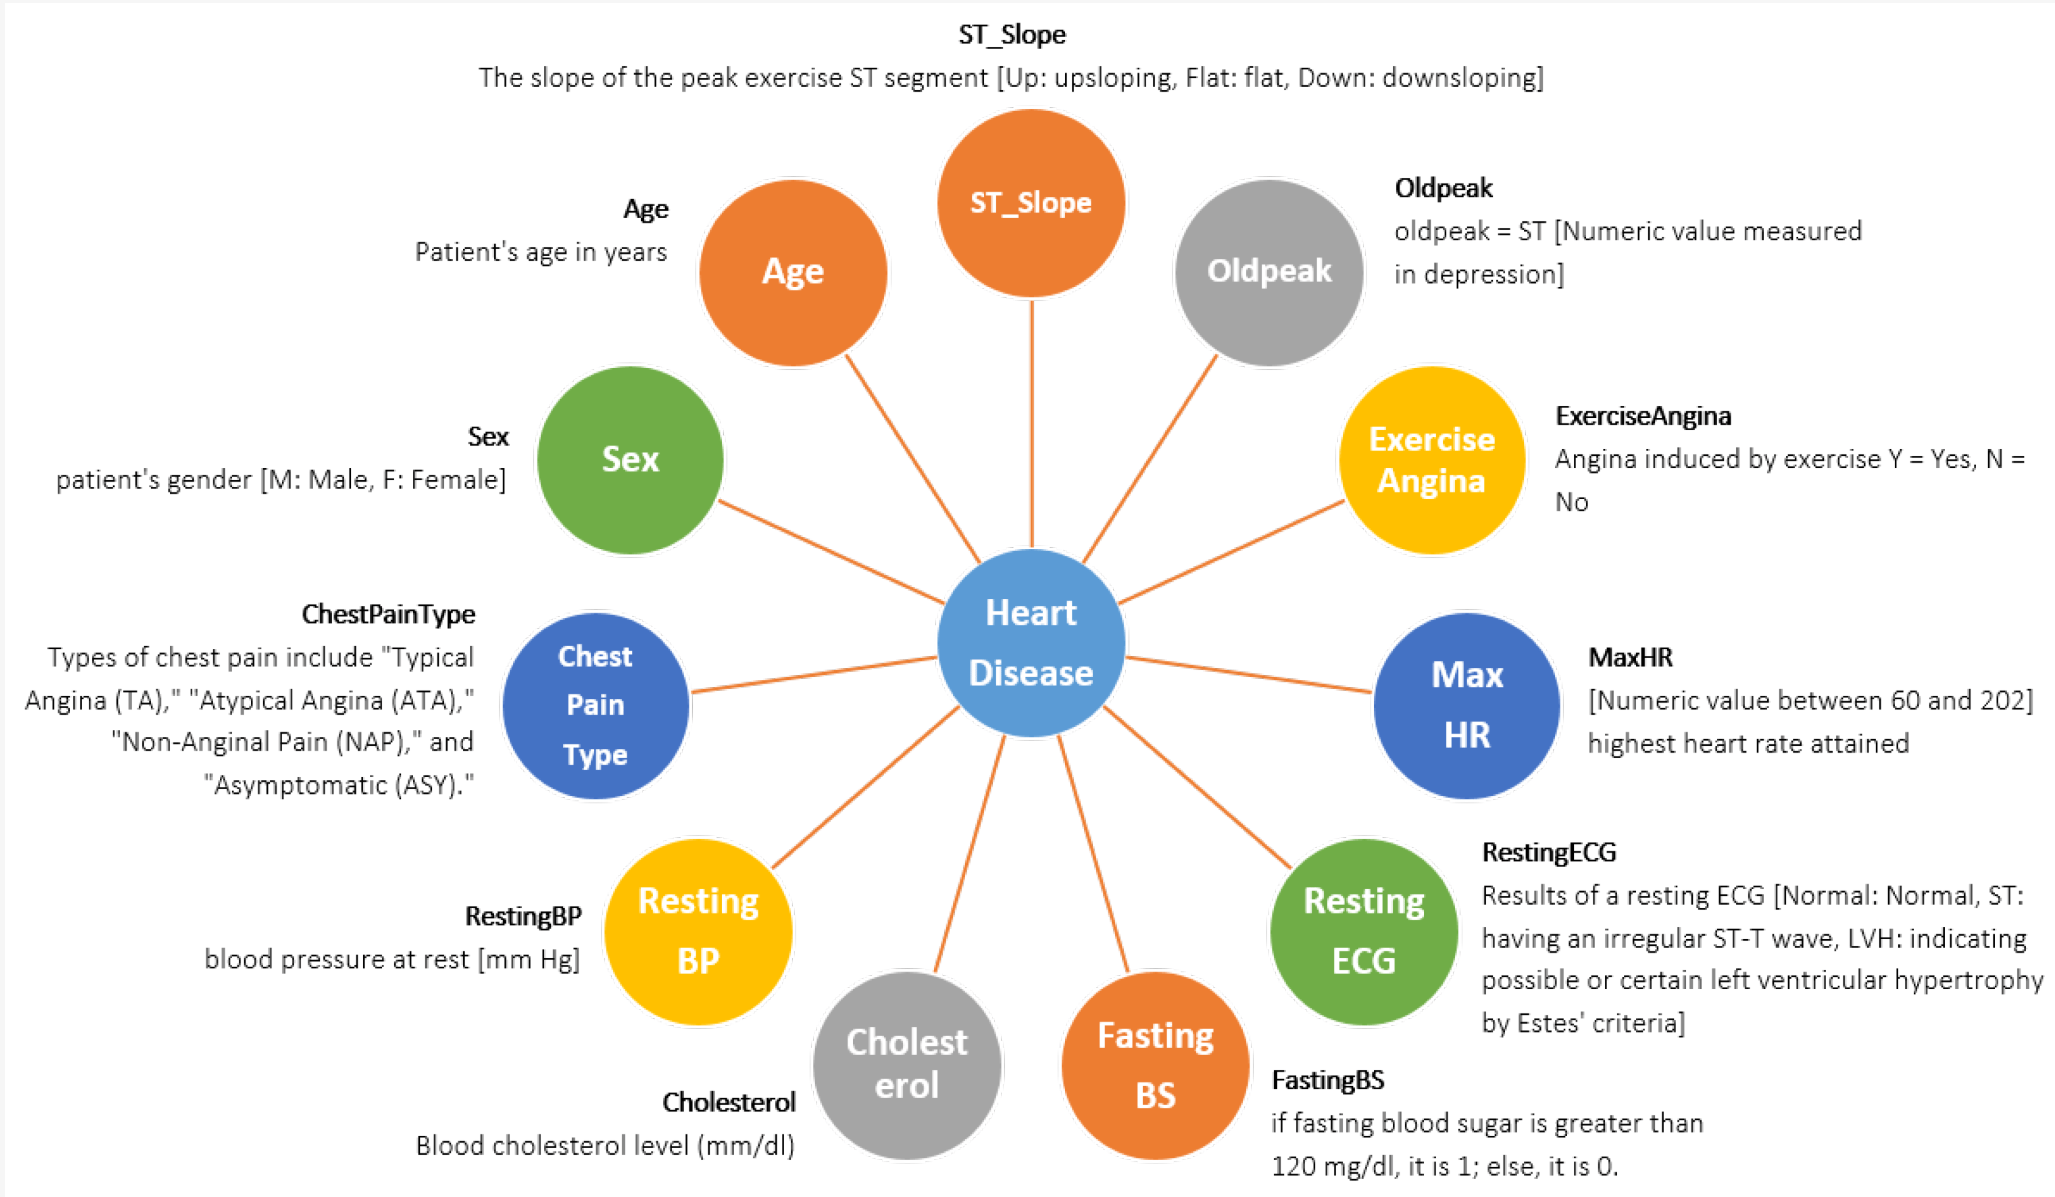

In [ ]:
#load data
db = pd.read_csv("heart.csv")
#we will use copy of our data for visualization and analysis
db_copy = db.copy()

# **Thông tin dữ liệu**

In [ ]:
df
#db
#statistic informations
df.describe()

# **Kiểm tra, quan sát phân tích, chuẩn hóa dữ liệu**

In [ ]:
# Kiểm tra dữ liệu trùng lặp
df.duplicated().sum()
#df.drop_duplicates(keep='first',inplace=True)

In [ ]:
# Kiểm tra các dòng trùng lặp
duplicate_rows = df[df.duplicated()]
print("\nCác dòng trùng lặp:")
print(duplicate_rows)

# Đếm số lượng dòng trùng lặp
num_duplicates = df.duplicated().sum()
print(f"\nSố lượng dòng trùng lặp: {num_duplicates}")

# Loại bỏ các dòng trùng lặp
df_cleaned = df.drop_duplicates()

# Kiểm tra lại sau khi loại bỏ
print("\nDataFrame sau khi loại bỏ các dòng trùng lặp:")
print(df_cleaned)

# Lưu DataFrame đã làm sạch vào file CSV nếu cần
#df_cleaned.to_csv('cleaned_data.csv', index=False)

In [ ]:
#value counts of categorical features
categoricalfeatures = ["ChestPainType","RestingECG","Sex","ExerciseAngina","ST_Slope"]
for i in categoricalfeatures:
    print(df[i].value_counts())
    print("***************************")

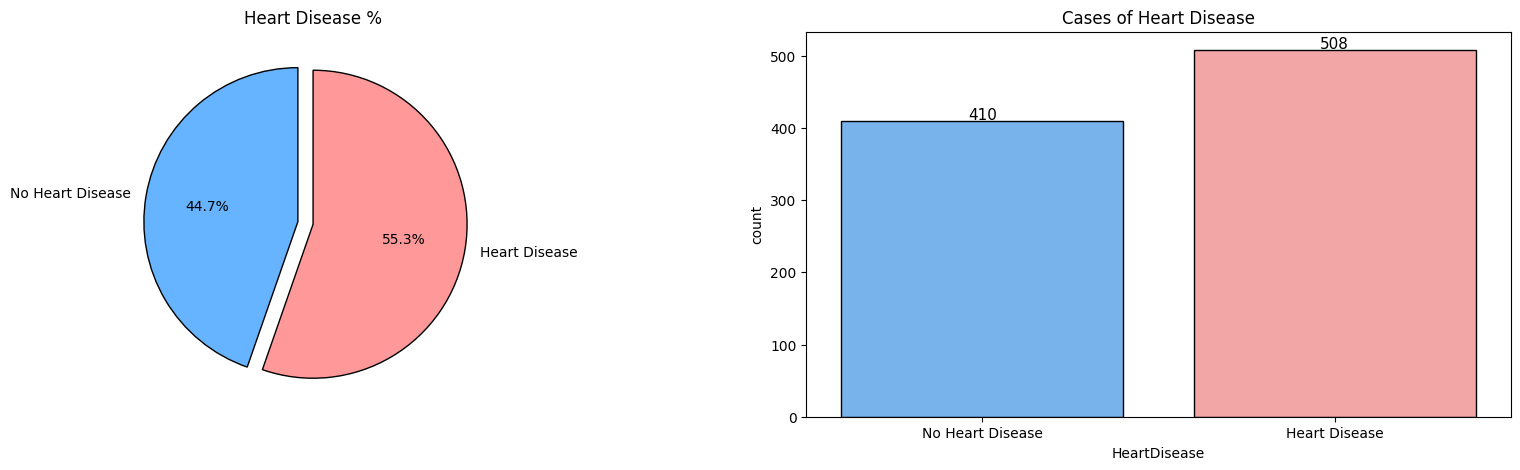

In [8]:
# Define colors for the plots
colors = ['#66b3ff', '#ff9999']  # Example colors (adjust as needed)

# Calculate percentages for the pie chart
l = list(df['HeartDisease'].value_counts())
circle = [l[1] / sum(l) * 100, l[0] / sum(l) * 100]

# Create subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

# Pie chart
plt.subplot(1, 2, 1)
plt.pie(
    circle,
    labels=['No Heart Disease', 'Heart Disease'],
    autopct='%1.1f%%',
    startangle=90,
    explode=(0.1, 0),
    colors=colors,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True}
)
plt.title('Heart Disease %')

# Countplot
plt.subplot(1, 2, 2)
# Assign `hue` to `x` and set `legend=False` to avoid FutureWarning
ax = sns.countplot(data=df, x='HeartDisease', hue='HeartDisease', palette=colors, edgecolor='black', legend=False)

# Add count labels on top of bars
for rect in ax.patches:
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        rect.get_height() + 2,
        int(rect.get_height()),  # Ensure the value is an integer
        horizontalalignment='center',
        fontsize=11
    )

# Set custom x-axis labels
ax.set_xticks([0, 1])  # Explicitly define tick positions
ax.set_xticklabels(['No Heart Disease', 'Heart Disease'])

# Add title
plt.title('Cases of Heart Disease')

# Show the plot
plt.show()

Remove duplicates
in this dataset we have a duplicate row. In order to get more accurate predictions we remove this clone
df.drop_duplicates(keep='first',inplace=True)

In [ ]:
cat_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
num_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [ ]:
for col in cat_cols:
    print(f'The unique values in {col} are: {df[col].unique()}')

In [ ]:
#Checking for Missing Values¶
df.isnull().sum()

Great! We don't have to deal with null values. We have separated the categorical and numerical columns and so we can now begin EDA.

In [ ]:
# Identify non-numeric columns
non_numeric_columns = df.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_columns)

# Drop non-numeric columns
df_numeric = df.select_dtypes(include=['number'])

# Compute Spearman correlation
corr = df_numeric.corr(method='spearman')

# Plot heatmap
plt.figure(figsize=(25, 10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Spearman Correlation Heatmap\n')
plt.show()

In [ ]:
pairplot_cols = num_cols
pairplot_cols.append('HeartDisease')
figure = plt.figure(figsize=(20,10))
sns.pairplot(df[pairplot_cols], hue='HeartDisease', palette='YlGnBu')
plt.show()

Something that I noticed in the cholesterol column is that there are a lot of entries with value as 0. Let's see how many such entries are there.

In [ ]:
df.loc[df['Cholesterol'] == 0, 'Cholesterol'].count()

In [ ]:
df.loc[(df['Cholesterol'] == 0) & (df['HeartDisease'] == 1), 'Cholesterol'].count()

In [ ]:
df.loc[df['RestingBP'] == 0, 'RestingBP'].count()

In [ ]:
df.loc[(df['RestingBP'] == 0) & (df['HeartDisease'] == 1), 'RestingBP'].count()

There are 172 values with cholesterol value 0 and I think this has been done to fill the missing data. Out of 172 values, 152 have heart disease. Let's just remove this column because these 172 values are basically missing values imputed with 0. We will remove it later using column transformer.

In [ ]:
#num_cols.remove('Cholesterol')
for column in df:
    print(column, ": ", sorted(df[column].unique()), end="\n\n")

Như chúng ta có thể thấy từ bản in này, chúng ta có các giá trị sai, chẳng hạn như cholesterol và restingBP. Các cột này có dữ liệu với giá trị 0, điều này không thể xảy ra. Để sửa lỗi, chúng ta sẽ thay thế các số 0 này bằng giá trị trung bình của toàn bộ cột.

In [ ]:
# Sample DataFrame (replace with your actual db)
df = pd.DataFrame(db)

# Replace zero values with mean
df.loc[df['RestingBP'] == 0, 'RestingBP'] = int(df['RestingBP'].mean())
df.loc[df['Cholesterol'] == 0, 'Cholesterol'] = int(df['Cholesterol'].mean())

# Print unique values
print("RestingBP: ", sorted(df['RestingBP'].unique()), end="\n\n")
print("Cholesterol: ", sorted(df['Cholesterol'].unique()), end="\n\n")

In [ ]:
#df.loc[df['Cholesterol'] == 0, 'Cholesterol'].count()
#df.loc[df['RestingBP'] == 0, 'RestingBP'].count()

In [ ]:
print("After:")
print("##### Type of columns #####")
print(df.info(), end="\n\n")
print("***************************")
print("##### Null Value #####")
print(df.isnull().sum(), end="\n\n")
print("***************************")
print("##### Chart of missing values #####")
#missingno.matrix(df, figsize=(15, 5))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots
fig, axes = plt.subplots(4, 3, figsize=(20, 25))

# Loop through numerical columns
for i, col in enumerate(num_cols[:4]):  # Limit to first 4 columns
    # Stripplot
    sns.stripplot(ax=axes[i][0], x='HeartDisease', y=col, data=df, palette='GnBu', jitter=True, hue='HeartDisease', legend=False)
    axes[i][0].set_title(f'{col} Stripplot')

    # Histogram with KDE
    sns.histplot(ax=axes[i][1], x=col, data=df, kde=True, bins=10, hue='HeartDisease', multiple='dodge', palette='GnBu')
    axes[i][1].set_title(f'{col} Histogram with KDE')

    # Boxplot
    sns.boxplot(ax=axes[i][2], x='HeartDisease', y=col, data=df, palette='GnBu', hue='HeartDisease')
    axes[i][2].set_title(f'{col} Boxplot')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
# Định nghĩa hàm để tính giới hạn cho các giá trị ngoại lệ (outliers) dựa trên khoảng tứ phân vị (IQR - Interquartile Range)
def outlier_limits(df, col_name, q1=0.25, q3=0.75):
    # Tính giá trị tứ phân vị thứ nhất (Q1) - 25% dữ liệu nằm dưới giá trị này
    quartile1 = df[col_name].quantile(q1)

    # Tính giá trị tứ phân vị thứ ba (Q3) - 75% dữ liệu nằm dưới giá trị này
    quartile3 = df[col_name].quantile(q3)

    # Tính khoảng IQR (Interquartile Range): Khoảng cách giữa Q3 và Q1
    interquantile_range = quartile3 - quartile1

    # Tính giới hạn trên: Các giá trị vượt quá giới hạn này được coi là outliers
    up_limit = quartile3 + 1.5 * interquantile_range

    # Tính giới hạn dưới: Các giá trị nhỏ hơn giới hạn này được coi là outliers
    low_limit = quartile1 - 1.5 * interquantile_range

    # Trả về hai giá trị: Giới hạn dưới và giới hạn trên
    return low_limit, up_limit

# Định nghĩa hàm thay thế các giá trị ngoại lệ bằng giới hạn đã tính
def replace_with_limits(df, variable, q1=0.25, q3=0.75):
    # Gọi hàm `outlier_limits` để lấy giới hạn dưới và giới hạn trên
    low_limit, up_limit = outlier_limits(df, variable, q1=q1, q3=q3)

    # Thay thế các giá trị nhỏ hơn giới hạn dưới bằng giá trị giới hạn dưới
    df.loc[(df[variable] < low_limit), variable] = low_limit

    # Thay thế các giá trị lớn hơn giới hạn trên bằng giá trị giới hạn trên
    df.loc[(df[variable] > up_limit), variable] = up_limit

# Lặp qua từng cột số trong DataFrame (các cột được lưu trong danh sách `num_cols`)
for variable in df[num_cols].columns:
    # Áp dụng hàm `replace_with_limits` để xử lý outliers cho từng cột số
    replace_with_limits(df, variable)

In [ ]:
#EDA
fig, axes = plt.subplots(2, 2, figsize=(20,15))
for i, col in zip(range(4), num_cols):
    sns.boxplot(ax=axes[i//2][i%2], x='HeartDisease', y=col, data=df, palette='GnBu', hue='HeartDisease')
    axes[i//2][i%2].set_title(f'{col} Boxplot')

In [ ]:
# Oldpeak still has a lot of outliers. We will look into it later when checking multicollinearity.
fig, axes = plt.subplots(2, 3, figsize=(20,12))
for i, col in zip(range(6), cat_cols):
    sns.histplot(ax=axes[i//3][i%3], x=col, data=df, palette='GnBu', hue='HeartDisease', multiple='dodge', bins='auto')
    axes[i//3][i%3].set_title(f'{col} Countplot')


In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(20,12))
for i, col in zip(range(6), cat_cols):
    sns.stripplot(ax=axes[i//3][i%3], x=col, y='Age', data=df, palette='GnBu', hue='HeartDisease', jitter=True)
    axes[i//3][i%3].set_title(f'{col} Countplot')

In [ ]:
# Let's now do some EDA for more than one feature, keeping the hue same as our target column.
eda_num_cols = ['RestingBP', 'MaxHR', 'Oldpeak','Cholesterol']

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(25,8))
for i, col in zip(range(4), eda_num_cols):
    sns.scatterplot(ax=axes[i], x='Age', y=col, hue="HeartDisease", style="Sex", data=df.iloc[0:889,:], palette="GnBu")

All features seem to be useful ahead as you can see that some categorical variables have certain values that have a lot of people with heart disease. The features aren't correlated which is good. With this, we are done with our EDA.

# Data Preprocessing

In [ ]:
num_cols.remove('HeartDisease')

In [ ]:
print(cat_cols)
print(num_cols)

We want to apply different types of encoding techniques for different variables. Let's use column transformer to achieve this.

In [ ]:
X = df.iloc[:,:11]
y = df['HeartDisease']
X.head()

In [ ]:
# Khai báo thư viện MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder từ thư viện sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder

# Khai báo thư viện ColumnTransformer từ thư viện sklearn.compose để tạo pipeline tiền xử lý dữ liệu
from sklearn.compose import ColumnTransformer

# Khai báo thư viện PCA từ thư viện sklearn.decomposition để giảm chiều dữ liệu
from sklearn.decomposition import PCA  # PCA: Principal Component Analysis

# Khai báo PCA với số lượng thành phần chính (n_components) là 2
pca = PCA(n_components=2)

# Tạo một ColumnTransformer (preprocessor1) để tiền xử lý dữ liệu:
# - Chuyển đổi các cột categorical (ChestPainType, ST_Slope, RestingECG, Sex, ExerciseAngina) sang one-hot encoding
# - Chuẩn hóa các cột numeric (num_cols) sử dụng MinMaxScaler (đưa các giá trị về khoảng [0, 1])
# - Các cột còn lại giữ nguyên (passthrough)
preprocessor1 = ColumnTransformer(# Khởi tạo các tiền xử lý
    transformers=[
        ('onehotcat', OneHotEncoder(), ['ChestPainType', 'ST_Slope', 'RestingECG', 'Sex', 'ExerciseAngina']),  # Transformer 1: OneHotEncoder cho các cột categorical
        ('num', MinMaxScaler(), num_cols),  # Transformer 2: MinMaxScaler cho các cột numeric
    ],
    remainder='passthrough',  # Các cột còn lại giữ nguyên (không được xử lý bởi bất kỳ transformer nào)
)

# Tạo một ColumnTransformer (preprocessor2) để tiền xử lý dữ liệu:
# - Áp dụng PCA cho các cột numeric (num_cols) để giảm chiều dữ liệu xuống 2 thành phần chính
# - Xóa các cột không cần thiết ('x0_ASY', 'x1_Down', 'x2_LVH', 'x3_F', 'x4_N', 'Age', 'RestingBP', 'MaxHR', 'Oldpeak', 'Cholesterol')
preprocessor2 = ColumnTransformer(
    transformers=[
        ('pca', pca, num_cols),  # Transformer 1: PCA cho các cột numeric
        ('dropper', 'drop', ['x0_ASY', 'x1_Down', 'x2_LVH', 'x3_F', 'x4_N', 'Age', 'RestingBP', 'MaxHR', 'Oldpeak', 'Cholesterol']),  # Transformer 2: Xóa các cột không cần thiết
    ],
    remainder='passthrough',  # Các cột còn lại giữ nguyên (không được xử lý bởi bất kỳ transformer nào)
)

In [ ]:
preprocessor1_features = ['x0_ASY', 'x0_ATA', 'x0_NAP', 'x0_TA', 'x1_Down', 'x1_Flat', 'x1_Up', 'x2_LVH', 'x2_Normal', 'x2_ST', 'x3_F', 'x3_M', 'x4_N', 'x4_Y', 'Age', 'RestingBP', 'MaxHR', 'Oldpeak', 'Cholesterol', 'FastingBS']
# Lấy các đặc trưng cuối cùng
final_features = ['PC-1', 'PC-2', 'x0_ATA', 'x0_NAP', 'x0_TA', 'x1_Flat', 'x1_Up', 'x2_Normal', 'x2_ST', 'x3_M', 'x4_Y', 'FastingBS']

sử dụng ColumnTransformer, các mục trong mảng đầu ra sẽ được sắp xếp theo thứ tự mã hóa. Do đó, các biến được mã hóa One-Hot Encoding (OHE) sẽ xuất hiện trước, tiếp theo là các biến đã được chuẩn hóa (scaled) và cuối cùng là các biến không cần tiền xử lý.
Để tránh bẫy biến giả (dummy variable trap) gây ra đa cộng tuyến, chúng ta sẽ loại bỏ 1 đặc trưng từ mỗi đặc trưng đã được mã hóa OHE.

In [ ]:
# Áp dụng tiền xử lý (fit_transform) của preprocessor1 lên DataFrame X
# và chuyển kết quả sang DataFrame mới với các cột được xác định bởi preprocessor1_features.
X = pd.DataFrame(preprocessor1.fit_transform(X), columns=preprocessor1_features)
# Áp dụng tiền xử lý (fit_transform) của preprocessor2 lên DataFrame X và chuyển kết quả sang DataFrame mới với các cột được xác định bởi final_features.
X = pd.DataFrame(preprocessor2.fit_transform(X), columns=final_features)
X.head()

**Sử dụng đoạn mã dưới đây để kiểm tra sự tồn tại của đa collinear giữa các đặc trưng (multicollinearity) bằng chỉ số VIF (Variance Inflation Factor). Các đặc trưng có VIF > 5 được coi là có đa collinear. Chúng ta sẽ chạy mã này để xác định những đặc trưng nào có đa collinear, sau đó quay lại bước tiền xử lý (Column Transformer) để thêm bước giảm chiều dữ liệu (PCA)**

In [ ]:
import statsmodels.api as sm
def calculate_vif(data):
    vif_df = pd.DataFrame(columns = ['Feature', 'VIF'])
    x_var_names = X.columns
    for i in range(0, x_var_names.shape[0]):
        y = X[x_var_names[i]]
        x = X[x_var_names.drop([x_var_names[i]])]
        r_squared = sm.OLS(y,x).fit().rsquared
        vif = round(1/(1-r_squared),2)
        vif_df.loc[i] = [x_var_names[i], vif]
    return vif_df.sort_values(by = 'VIF', axis = 0, ascending=False, inplace=False)

calculate_vif(X)

Các cột số liệu đang biểu hiện hiện tượng đa cộng tuyến. Thay vì loại bỏ các cột số liệu này, tốt hơn là giảm chiều dữ liệu của chúng bằng phương pháp Phân tích Thành Phần Chính (PCA), đồng thời cũng giúp giảm VIF (Variance Inflation Factor). Các đặc trưng số liệu chứa đựng thông tin quan trọng. Chúng ta có thể thêm một bộ tiền xử lý thứ hai (preprocessor2) chứa bước PCA vào đường dẫn xử lý (pipeline).

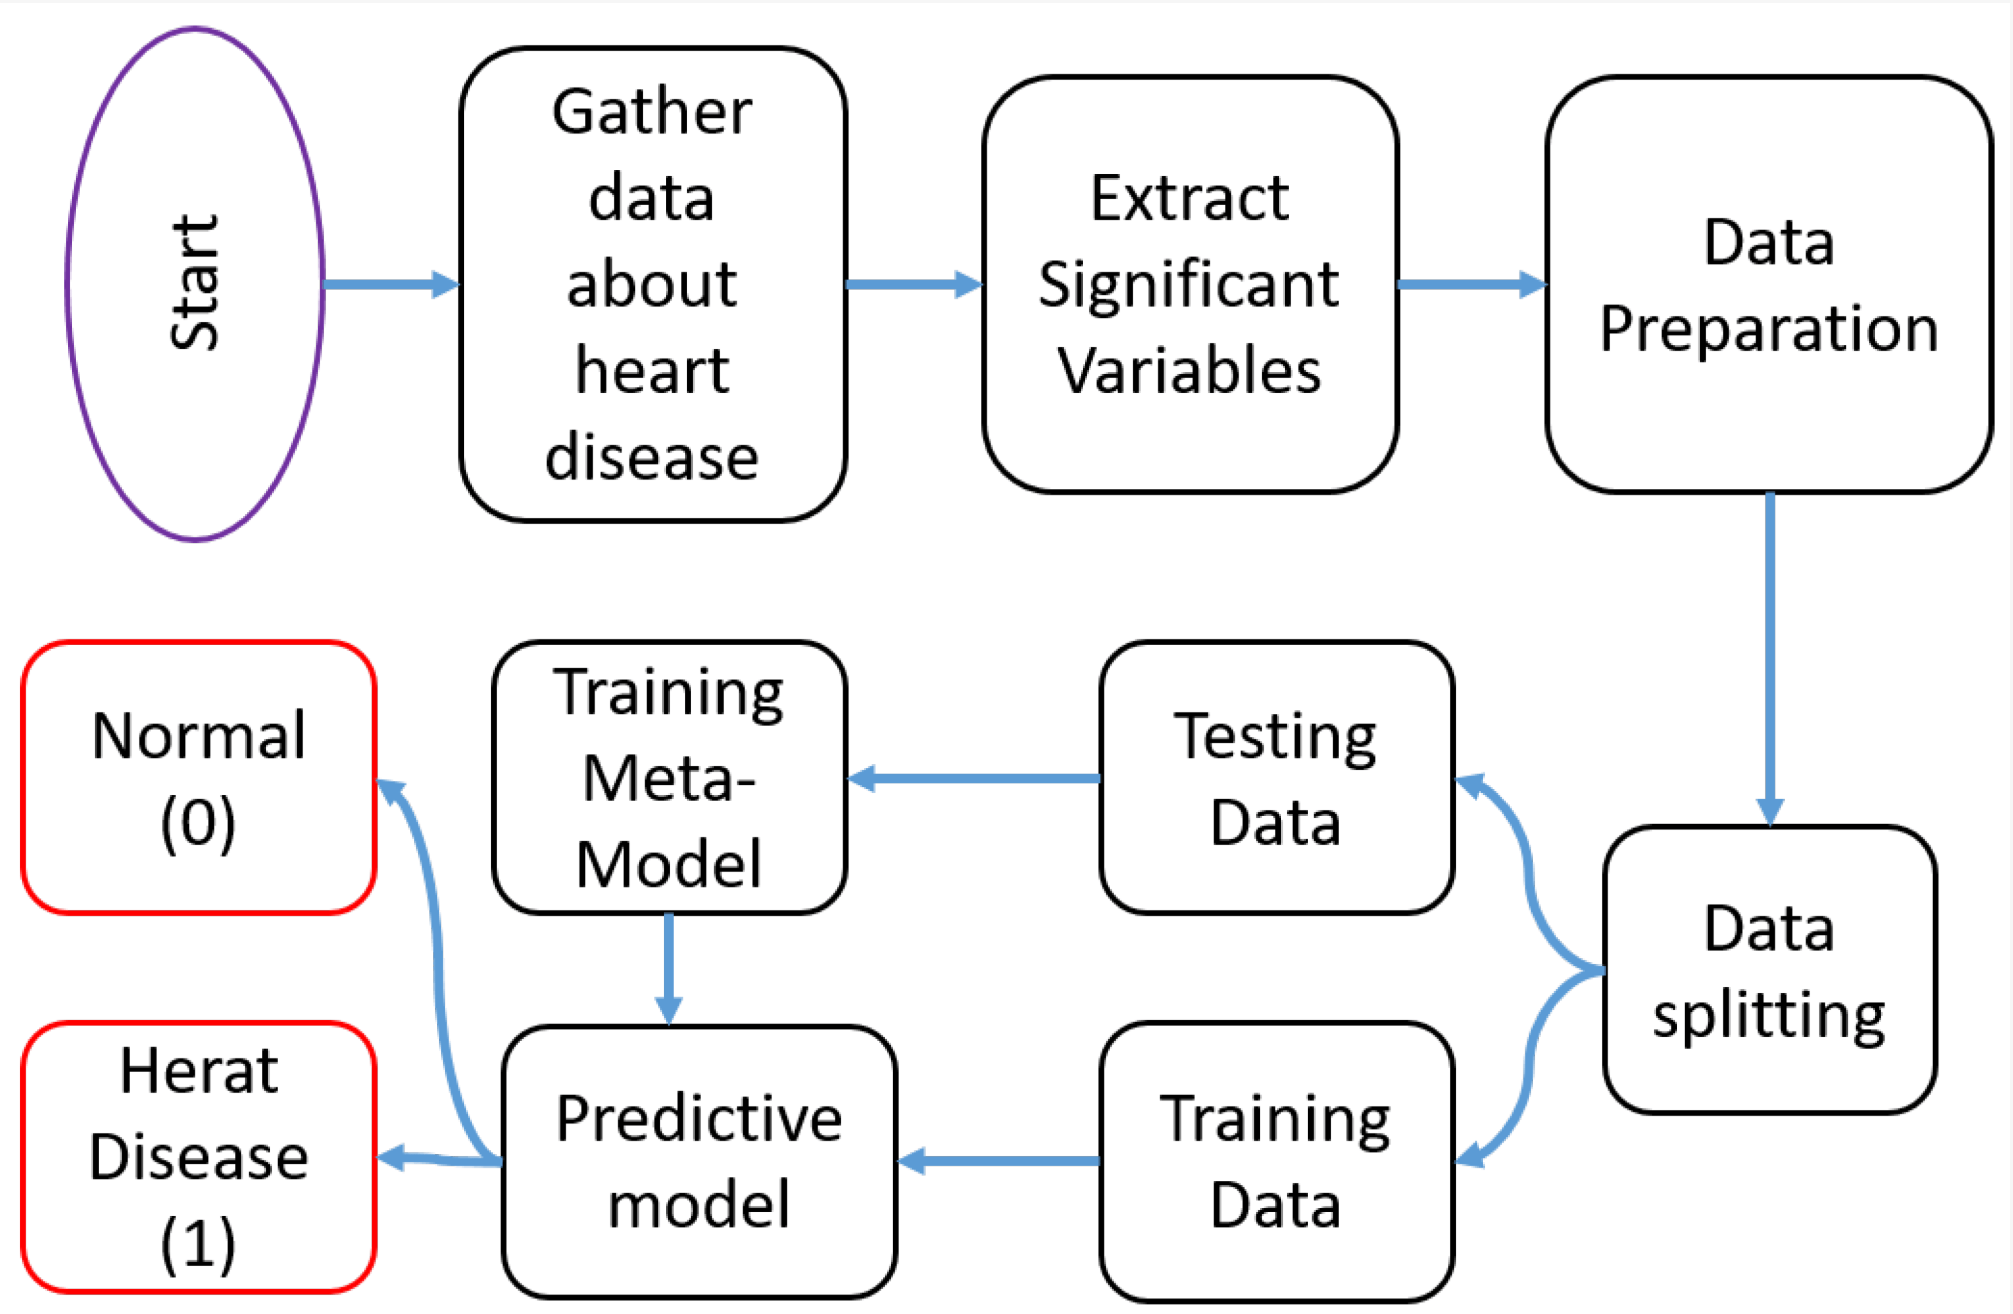

# **Machine Learning**
We will split the data first, apply different models and optimize them.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import classification_report
#import lightgbm as lgb

#from catboost import CatBoostClassifier

In [ ]:
#statistic informations
X.describe()

In [ ]:
# Giả sử X và y là dữ liệu đầu vào và nhãn tương ứng
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
print(y_train,y_test)


# **Các hàm sử dụng trong dự án.**

In [ ]:
def fit(clf, params, cv=10, X_train=X_train, y_train=y_train):
    grid = GridSearchCV(clf, params, cv=KFold(n_splits=cv), n_jobs=1, verbose=1, return_train_score=True, scoring='accuracy', refit=True) #verbose and n_jobs help us see the computation time and score of a cv. Higher the value of verbose, more the information printed out.
    grid.fit(X_train, y_train)
    return grid

def make_predictions(model, X_test=X_test):
    return model.predict(X_test)

def best_scores(model):
    # print(f'The mean cross validation test score is: {model.cv_results_.mean_test_score}') #for some reason this wasn't working for me even though the attribute exists so lets just leave it.
    print(f'The best parameters are: {model.best_params_}')
    print(f'The best score that we got is: {model.best_score_}')
    return None

def plot_confusion_matrix(y_pred):

     # Confusion Matrix
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

    # Tạo nhãn cho mỗi ô trong ma trận
    names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    # Vẽ ma trận nhầm lẫn bằng Seaborn
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.4)  # Tăng kích thước font
    heatmap = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=True, square=True, xticklabels=['0', '1'], yticklabels=['0', '1'])

    # Đặt tiêu đề và nhãn trục
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize=14)

    # Hiển thị đồ thị
    plt.show()

def check_scores(y_pred):
    print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
    print('Precision: %.2f' % precision_score(y_test, y_pred))
    print('Recall: %.2f' % recall_score(y_test, y_pred))
    print('F1 Score: %.2f' % f1_score(y_test, y_pred))
    # Classification Report
    print(classification_report(y_true=y_test, y_pred=y_pred))
    return None


# **Model Logistic Regression**

In [ ]:

# Định nghĩa tham số cho GridSearchCV
lr_params = {'C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25], 'penalty': ['l1', 'l2']}
lr_clf = LogisticRegression(solver='saga', max_iter=5000)

# Tìm kiếm tham số tốt nhất bằng GridSearchCV
grid_search = GridSearchCV(lr_clf, lr_params, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)


In [ ]:
# Lấy mô hình tốt nhất
lr_model = grid_search.best_estimator_

In [ ]:
# Dự đoán nhãn cho tập kiểm tra
y_pred = lr_model.predict(X_test)
# In ra classification report
print("Classification Report Model Logistic Regression:")
check_scores(y_pred)
##plt.title('Confusion Matrix Model Logistic Regression', fontsize=16)
plot_confusion_matrix(y_pred)


"""
    Hàm tính ROC-AUC cho một mô hình phân loại và vẽ đường cong ROC-AUC (nếu plot=True).

    Tham số:
    - model: Mô hình đã được huấn luyện.
    - X_test: Dữ liệu kiểm tra.
    - y_test: Nhãn kiểm tra.
    - plot: Nếu True, sẽ vẽ đường cong ROC-AUC.

    Trả về:
    - roc_auc: Giá trị AUC của mô hình.
    """

In [ ]:
# Dự đoán xác suất cho tập kiểm tra
y_pred_prob = lr_model.predict_proba(X_test)[:, 1]

# Tính toán fpr, tpr và AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# In ra AUC score
print(f"Logistic Regression AUC: {roc_auc:.4f}")

# Vẽ ROC-AUC curve
plt.figure(figsize=(10, 8))
plt.grid()

# Vẽ đường cong ROC-AUC
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc:.2f})')

# Vẽ đường chéo Random Classifier
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random Classifier')

# Vẽ Perfect Classifier
plt.plot([0, 0, 1], [0, 1, 1], color='black', linestyle=':', lw=2, label='Perfect Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve of Model Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# **Model Support Vector Machine**

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report
import matplotlib.pyplot as plt

# Định nghĩa mô hình SVM
svm_clf = SVC(probability=True, random_state=42)

# Định nghĩa không gian tham số
svm_params = {
    'C': [1, 10, 100, 1000],          # Tham số C điều chỉnh mức độ phạt lỗi phân loại
    'gamma': [1, 0.1, 0.001, 0.0001], # Tham số gamma điều chỉnh độ rộng của kernel RBF
    'kernel': ['linear', 'rbf']       # Loại kernel: linear hoặc RBF
}

In [ ]:
# Sử dụng GridSearchCV để tìm siêu tham số tối ưu
grid_search = GridSearchCV(estimator=svm_clf, param_grid=svm_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Lấy mô hình tốt nhất từ GridSearchCV
svm_model = grid_search.best_estimator_

In [ ]:
# Dự đoán xác suất cho tập kiểm tra
y_pred_prob = svm_model.predict_proba(X_test)[:, 1]

# Tính toán FPR, TPR và AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# In ra AUC score
print(f"Support Vector Machine AUC: {roc_auc:.4f}")

# Vẽ ROC-AUC curve
plt.figure(figsize=(10, 8))
plt.grid()

# Vẽ đường cong ROC-AUC
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Support Vector Machine (AUC = {roc_auc:.2f})')

# Vẽ đường chéo Random Classifier
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random Classifier')

# Vẽ Perfect Classifier
plt.plot([0, 0, 1], [0, 1, 1], color='black', linestyle=':', lw=2, label='Perfect Classifier')

# Thiết lập giới hạn trục và nhãn
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve of Support Vector Machine")
plt.legend(loc="lower right")
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

# Đánh giá mô hình
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
# In ra classification report
print("Classification Report Model Support Vector Machine:")
check_scores(y_pred)
##plt.title('Confusion Matrix Model Logistic Regression', fontsize=16)
plot_confusion_matrix(y_pred)


# **Model Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define parameters for Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the Random Forest classifier
rf_clf = RandomForestClassifier(random_state=42)

In [ ]:
# Fit the model using GridSearchCV
rf_model = fit(rf_clf, rf_params)

In [ ]:
# Print the best scores and parameters
best_scores(rf_model)

In [ ]:
# Make predictions on the test set
rf_y_pred = make_predictions(rf_model)

# Evaluate the model
check_scores(rf_y_pred)
plot_confusion_matrix(rf_y_pred)

# Dự đoán xác suất cho tập kiểm tra
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

# Tính toán FPR, TPR và AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# In ra AUC score
print(f"Support Vector Machine AUC: {roc_auc:.4f}")

# Vẽ ROC-AUC curve
plt.figure(figsize=(10, 8))
plt.grid()

# Vẽ đường cong ROC-AUC
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Support Vector Machine (AUC = {roc_auc:.2f})')

# Vẽ đường chéo Random Classifier
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random Classifier')

# Vẽ Perfect Classifier
plt.plot([0, 0, 1], [0, 1, 1], color='black', linestyle=':', lw=2, label='Perfect Classifier')

# Thiết lập giới hạn trục và nhãn
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve of Support Vector Machine")
plt.legend(loc="lower right")
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

# Đánh giá mô hình
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
# In ra classification report
print("Classification Report Model Support Vector Machine:")
check_scores(y_pred)
##plt.title('Confusion Matrix Model Logistic Regression', fontsize=16)
plot_confusion_matrix(y_pred)



In [ ]:
# Split data into training and validation sets
RANDOM_STATE = 1
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=RANDOM_STATE)

# Print the number of samples in each set
print(f'Train samples: {len(X_train)}')
print(f'Validation samples: {len(X_val)}')

# Print the target proportion in the training set
print(f'Target proportion: {sum(y_train)/len(y_train):.4f}')

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
# FEATURE SCALING
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


# EVALUATING VARIOUS MODELS
model_scores, best_model_info = [], []


# **Thuật toán ML _ XGBoost**

In [ ]:
from xgboost import XGBClassifier  # Đảm bảo import XGBClassifier từ xgboost

# Định nghĩa mô hình
n = int(len(X_train) * 0.75)  # Let's use 80% to train and 20% to eval
X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train[:n], X_train[n:], y_train[:n], y_train[n:]

xgb = XGBClassifier(n_estimators=500, learning_rate=0.01, verbosity=1, early_stopping_rounds=10,
                    random_state=2)
xgb.fit(X_train_fit,y_train_fit, eval_set=[(X_train_eval, y_train_eval)])
xgb.best_iteration

y_pred = xgb.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
train_score = xgb.score(X_train, y_train)
report = classification_report(y_val, y_pred)

print(f'Train Accuracy: {train_score:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')
print('Classification Report for {}:\n{}'.format('XGBoost', report))

model_scores.append({
        'model': 'XGBoost',
        'train_score': train_score,
        'test_score': accuracy})

# Tính toán ma trận nhầm lẫn (confusion matrix)
cm = confusion_matrix(y_val, y_pred, labels=np.unique(y_val))

# Tạo nhãn cho ma trận nhầm lẫn
names = ['True Negative','False Positive','False Negative','True Positive']
counts = [value for value in cm.flatten()]
percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, percentages)]
labels = np.asarray(labels).reshape(2,2)

# Vẽ ma trận nhầm lẫn bằng Seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)  # Tăng kích thước font
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=True, square=True, xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix (XGBoost)', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.show()


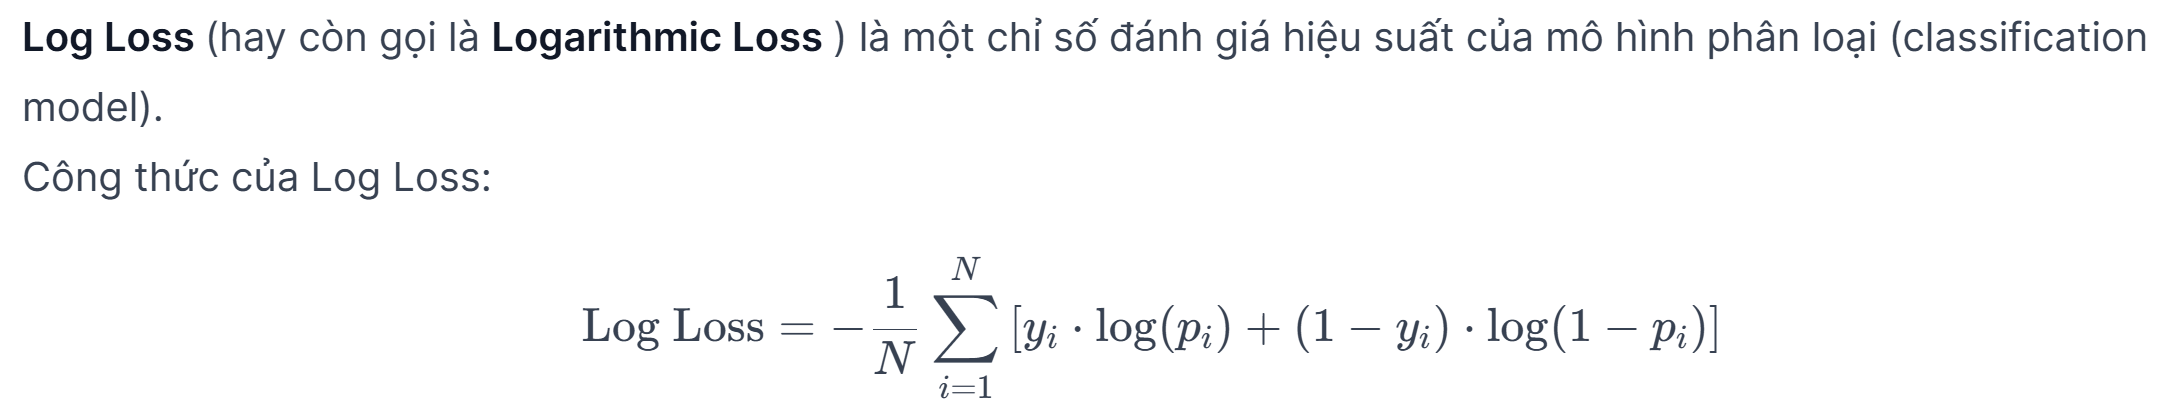

Trong đó:
N: Số lượng mẫu dữ liệu.

yi: Giá trị thực tế (ground truth) của mẫu thứ i (1 nếu thuộc lớp dương, 0 nếu thuộc lớp âm).

pi: Xác suất dự đoán của mô hình cho lớp dương của mẫu thứ i.

Ý nghĩa :
Log Loss đo lường mức độ sai lệch giữa giá trị dự đoán và giá trị thực tế.
Giá trị Log Loss càng nhỏ thì mô hình càng tốt.
Log Loss phạt nặng hơn khi mô hình dự đoán sai với xác suất cao (ví dụ: dự đoán xác suất 99% nhưng kết quả thực tế lại sai).

In [ ]:
from sklearn.metrics import roc_curve, auc

# Tính xác suất dự đoán cho lớp dương (class 1)
y_pred_prob = xgb.predict_proba(X_val)[:, 1]

# Tính các điểm trên đường cong ROC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

# Tính giá trị AUC
roc_auc = auc(fpr, tpr)

# In giá trị AUC
print(f'ROC AUC Score: {roc_auc:.4f}')

# Vẽ đường cong ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Đường chéo biểu thị mô hình ngẫu nhiên
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

# **sử dụng Tensorflow**

In [ ]:
!pip install tensorflow

In [ ]:
!pip install scikeras

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Bước 3: Xây dựng mô hình TensorFlow
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
# Compile mô hình
model.compile(
    optimizer='adam',  # Tối ưu hóa bằng Adam
    loss='binary_crossentropy',  # Hàm mất mát cho bài toán phân loại nhị phân
    metrics=['accuracy']  # Đo lường độ chính xác
)

# Bước 4: Huấn luyện mô hình
history = model.fit(
    X_train, y_train,
    epochs=150,  # Số lần lặp qua toàn bộ dữ liệu
    batch_size=32,  # Kích thước batch
    validation_split=0.2,  # Dùng 20% dữ liệu huấn luyện làm tập validation
    verbose=1  # Hiển thị tiến trình
)

# Bước 5: Đánh giá mô hình trên tập kiểm tra
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Dự đoán trên tập kiểm tra
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# In kết quả dự đoán
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# Vẽ đồ thị loss và accuracy
import matplotlib.pyplot as plt

# Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Model neural_network đang fix**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [ ]:
# 1. Đọc dữ liệu
#data = pd.read_csv("hearts.csv")

# **1.   Write Function**


In [ ]:
#hidden_layer is node in hidden layer
#hidden_layer sample [5,5,X] X for clasification = number of class
def neural_network_create_weight_bias(feature_list, hidden_layer):
    #create empty weight list
    weight = []
    #create empty bias list
    bias = []
    #for in layer of hidden layer
    for i in range(len(hidden_layer)):

        #create bias_i
        #bias appear in hidden_layer only
        #create bias_i row = 1,column = number of node of  hidden_layer[i]
        bias_i_column = hidden_layer[i]
        #create bias_i
        bias_i = np.random.randn(1, bias_i_column)

        #create weigth_i
        if i <= 0:
            #first weigth_i
            #create weigth_i row = column of feature
            weight_i_row = feature_list.shape[1]

        else:
            #other weigth_i
            #create weigth_i row = number of node of hidden_layer[i-1]
            weight_i_row = hidden_layer[i-1]

        #create weigth_i column = number of node of  hidden_layer[i]
        weight_i_column = hidden_layer[i]
        #create weigth_i
        weight_i = np.random.randn(weight_i_row, weight_i_column)

        #improve weight and bias
        #improve bias_i using devine by square root of number of node in hidden_layer[i]
        bias_i = bias_i/np.sqrt(hidden_layer[i])
        #improve weight_i using devine by square root of number of node in hidden_layer[0]
        weight_i = weight_i/np.sqrt(hidden_layer[0])

        #add list
        #add bias_i to bias list
        bias.append(bias_i)
        #add weight_i to weight list
        weight.append(weight_i)

    return weight, bias

In [ ]:
def neural_network_forward(feature_list, weight, bias, activate_function):
    #create empty list of output
    output = []
    #create empty list of activated_output
    activated_output = []

    #for activate_function
    for i in range(len(activate_function)):

        if i <= 0:
            #first layer calculate output_i from feature_list
            output_i = np.dot(feature_list, weight[i]) + bias[i]
        else:
            #first layer calculate output_i from last activated_output
            output_i = np.dot(activated_output[-1], weight[i]) + bias[i]

        #compute_activated_output by activate_function[i]
        activated_output_i = neural_network_compute_activated_output(output_i, activate_function[i])

        #add output_i and activated_output_i to list
        output.append(output_i)
        activated_output.append(activated_output_i)

    return output,activated_output

In [ ]:
def neural_network_compute_activated_output(output_i, activate_function):
    if type(activate_function) == str:

        if activate_function == 'sigmoid':
            #sigmoid : activated_output_i = 1/(1+e^(-output_i))
            activated_output_i = 1/(1 + np.exp(-output_i))

        elif activate_function == 'tanh':
            #hyperbolic tangent : activated_output_i = ((e^output_i)-(e^-output_i))/((e^output_i)+(e^-output_i))
            activated_output_i = (np.exp(output_i) - np.exp(-output_i))/(np.exp(output_i) + np.exp(-output_i))

        elif activate_function == 'ReLU':
            #rectified linear unit : activated_output_i = if output_i <= 0 : 0, if output_i > 0 : output_i
            activated_output_i = output_i * (output_i > 0)

        elif activate_function == 'softmax':
            #softmax : e^output_i/sum(e^output_i)
            activated_output_i = np.exp(output_i)/np.exp(output_i).sum(axis=1, keepdims = True)

    elif type(activate_function) == list:

        if activate_function[0] == 'PReLU':
            #parametric rectified linear unit : activated_output_i = if output_i <= 0 : output_i * new_slope , if output_i > 0 : output_i
            #remark slope != 1
            activated_output_i = output_i * (output_i > 0) + activate_function[1] * output_i * (output_i <= 0)

    return activated_output_i

In [ ]:
def neural_network_compute_different(output_i, activated_output_i, activate_function_i):

    if type(activate_function_i) == str:

        if activate_function_i == 'sigmoid':
            different_i = activated_output_i * (1 - activated_output_i)

        elif activate_function_i == 'tanh':
            different_i = 1 - activated_output_i**2

        elif activate_function_i == 'ReLU':
            different_i = (output_i > 0)

    elif type(activate_function_i) == list:

        if activate_function_i[0] == 'PReLU':
            different_i = (output_i > 0) + activate_function_i[1] * (output_i <= 0)

    return different_i
def neural_network_compute_error(delta_i, different_i):
    error_i = delta_i * different_i
    return error_i
def find_error(target_list, output, error_type):

    if error_type == 'SSE':
        error = find_sum_square_error(target_list, output)

    elif error_type == 'MSE':
        error = find_mean_square_error(target_list, output)

    elif error_type == 'MAE':
        error = find_mean_absolute_error(target_list, output)

    elif error_type == 'MAPE':
        error = find_mean_absolute_percentage_error(target_list, output)

    elif error_type == 'Entropy':
        error = find_entropy_error(target_list, output)

    elif error_type == 'Binary':
        error = find_binary_class_error(target_list, output)

    elif error_type == 'Multiclass':
        error = find_multi_class_error(target_list, output)

    return error

In [ ]:
def find_sum_square_error(target_list, output):
    sum_square_error = ((target_list - output)**2).sum()
    return sum_square_error


In [ ]:
def find_mean_square_error(target_list, output):
    number_of_sample = target_list.shape[0]
    sum_square_error = ((target_list - output)**2).sum()
    mean_square_error = sum_square_error/number_of_sample
    return mean_square_error

In [ ]:
def find_mean_absolute_error(target_list, output):
    number_of_sample = target_list.shape[0]
    mean_absolute_error = (np.abs(target_list - output)).sum()/number_of_sample
    return mean_absolute_error

In [ ]:
def find_mean_absolute_percentage_error(target_list, output):
    number_of_sample = target_list.shape[0]
    mean_absolute_percentage_error = np.abs((target_list - output)/target_list).sum()*100/number_of_sample
    return mean_absolute_percentage_error

In [ ]:
def find_entropy_error(target_list, output):
    log_output = np.log(output)
    entropy_error = (-target_list*log_output).sum()
    return entropy_error

In [ ]:
def find_binary_class_error(target_list, output):
    number_of_sample = target_list.shape[0]
    _target_list = np.round(target_list, 0)
    _output = np.round(output, 0)
    binary_class_error = 100*(_target_list != _output).sum()/number_of_sample
    return binary_class_error

In [ ]:
def find_multi_class_error(target_list, output):
    number_of_sample = target_list.shape[0]
    argmax_of_target_list = np.argmax(target_list, axis=1)
    argmax_of_output = np.argmax(output, axis=1)
    multi_class_error = 100*(argmax_of_target_list != argmax_of_output).sum()/number_of_sample
    return multi_class_error

In [ ]:
def create_onehot_target(label):

    #define unique_label for column
    unique_label = len(np.unique(label))

    #define number_of_label for row
    number_of_label = label.shape[0]

    #create zeros metrix column = number_of_label, row = unique_label
    onehot = np.zeros([number_of_label, unique_label])

    for i in range(number_of_label):
        #add 1 at label type for each row in zeros metrix
        onehot[i, label[i]] = 1

    return onehot

In [ ]:
def neural_network_classification_find_weight_bias(feature_list, target_list, hidden_layer, activate_function, weight = [], bias = [], epoch = 1000, learning_rate = 0.01, lambda1 = 0, lambda2 = 0, dropout = False, prob_drop = [0]):

    #number_of_layer = length of hidden_layer
    number_of_layer = len(hidden_layer)
    #number_of_trianing_data = row of feature_list
    number_of_trianing = feature_list.shape[0]

    #if weight == [] create a new one
    if not weight:
        weight, bias = neural_network_create_weight_bias(feature_list, hidden_layer)

    #create empty error_list
    error_list = []
    percent = 0
    for i in range(epoch):

        #print progress
        new_percent = int(i*100/epoch)
        if(new_percent > percent):
            percent = new_percent
            print(percent)

        #calculate output and activated output for each hidden layer
        output, activated_output = neural_network_forward(feature_list, weight, bias, activate_function)

        #find error using output of last layer
        #find error by entropy error using "Entropy"
        error = find_error(target_list, activated_output[-1], 'Entropy')
         #collact error in error_list for error trend
        error_list.append(error)

        #calculate slope of weight and bias by backpropagation
        slope_of_weight, slope_of_bias = neural_network_classification_backpropagation(feature_list, weight, bias, output, activated_output, target_list, activate_function, dropout, prob_drop)

        #loop = number of layer for create new weight,bias using gradient descent
        for layer_i in range(number_of_layer):
            #gradient descent weight_new = weight - (learning_rate * (1/n) * slope_of_weight)
            #add L1 and L2 regularization using lambda1 and lambda2
            weight[layer_i] = weight[layer_i] + (learning_rate * (1/number_of_trianing) * slope_of_weight[layer_i]) - lambda1*np.sign(weight[layer_i]) - lambda2*weight[layer_i]
            bias[layer_i] = bias[layer_i] + (learning_rate * (1/number_of_trianing) * slope_of_bias[layer_i]) - lambda1*np.sign(bias[layer_i]) - lambda2*bias[layer_i]
    return weight, bias, error_list

In [ ]:
def neural_network_classification_backpropagation(feature_list, weight, bias, output, activated_output, target_list, activate_function, dropout, prob_drop):

    #number_of_layer = length of activate_function
    number_of_layer = len(activate_function)

    #create empty list
    slope_weight = []
    slope_bias = []

    #for begin in last layer
    index_of_last_layer = number_of_layer - 1
    #step -1, stop at 0
    #range(start,stop,step)
    for i in range(index_of_last_layer, -1, -1):

        if i >= number_of_layer - 1:
            #last layer delta = target_list - activated_output of last layer
            delta_i = target_list - activated_output[i]
            different_i = 1
        else:
            #other layer delta_i = error_i of layer [i+1] . transpose(weight of layer [i+1])
            #remark use error_i = error_i of layer [i+1] because error_i is collected by previous round of loop
            delta_i = np.dot(error_i, weight[i+1].T)
            different_i = neural_network_compute_different(output[i], activated_output[i], activate_function[i])

        #collect error_i to error_i for calculate previous layer
        error_i = neural_network_compute_error(delta_i, different_i)

        if i <= 0:
            #at first layer slope_weight_i = transpose(feature_list) . error_i
            slope_weight_i = np.dot(feature_list.T, error_i)
        else:
            #other layer slope_weight_i = transpose(activated_output of [i-1] layer) . error_i
            slope_weight_i = np.dot(activated_output[i-1].T, error_i)

        if dropout == False:
            if i <= 0:
                #at first layer slope_weight_i = transpose(feature_list) . error_i
                slope_weight_i = np.dot(feature_list.T, error_i)
            else:
                #other layer slope_weight_i = transpose(activated_output of [i-1] layer) . error_i
                slope_weight_i = np.dot(activated_output[i-1].T, error_i)

                #slope_bias_i = sum(error_i)
                slope_bias_i = error_i.sum(axis=0)
        else:
            #create drop out node list for each layer
            dropout_node_list = neural_network_random_dropout_node(hidden_layer, prob_drop)

            if i > 0:
                #at other layer drop
                slope_weight_i = np.dot((activated_output[i-1]*dropout_node_list[i-1]).T, error_i)
            else:
                #at first layer not drop
                slope_weight_i = np.dot(feature_list.T, error_i)

            if i >= number_of_layer - 1:
                #at last layer not drop
                slope_bias_i = error_i.sum(axis=0)
            else:
                #at other layer drop
                slope_bias_i = (error_i*dropout_node_list[i]).sum(axis=0)


        #slope_bias_i = sum(error_i)
        slope_bias_i = error_i.sum(axis=0)

        #add slope_weight_i,slope_bias_i to list
        slope_weight.append(slope_weight_i)
        slope_bias.append(slope_bias_i)

    #convert [slope_weight_3,slope_weight_2,slope_weight_1] to [slope_weight_1,slope_weight_2,slope_weight_3]
    slope_weight =  slope_weight[::-1]
    slope_bias =  slope_bias[::-1]

    return slope_weight, slope_bias

In [ ]:
def neural_network_random_dropout_node(hidden_layer, prob_drop):
    dropout_node_list = []
    for i in range(len(hidden_layer)):
        dropout_node = np.random.choice([False, True], [1, hidden_layer[i]], p = [prob_drop[i], 1 - prob_drop[i]])
        dropout_node_list.append(dropout_node)
    return dropout_node_list

In [ ]:
def train_test_split(feature_list, target_list, train_size_percent = 80):

    #define N
    number_of_data = feature_list.shape[0]

    #random for split
    arr_rand = np.random.rand(number_of_data)

    #split random array using train_size_percent
    split = arr_rand < np.percentile(arr_rand, train_size_percent)

    #split
    feature_list_train = feature_list[split]
    target_list_train = target_list[split]
    feature_list_test =  feature_list[~split]
    target_list_test = target_list[~split]

    return feature_list_train,target_list_train,feature_list_test,target_list_test

Normalization


# **New section**

In [ ]:
def standardization(data, mean_norm, std_norm):
    data_norm = (data - mean_norm)/std_norm
    return data_norm
def std_for_norm(data):
    _std = data.std(axis=0)
    return _std.reshape(1, -1)

def mean_for_norm(data):
    _mean = data.mean(axis=0)
    return _mean.reshape(1, -1)

def de_standardization(data_norm, mean_norm, std_norm):
    data = data_norm*std_norm + mean_norm
    return data

# **Read Data & Prepare Data**

In [ ]:
#read data values
raw_csv = pd.read_csv("hearts.csv")
#raw_data = raw_csv.values


In [ ]:
# Sample DataFrame (replace with your actual db)
raw_data = pd.DataFrame(raw_csv)

In [ ]:
raw_data.loc[raw_data['Cholesterol'] == 0, 'Cholesterol'].count()
raw_data.loc[(raw_data['Cholesterol'] == 0) & (raw_data['HeartDisease'] == 1), 'Cholesterol'].count()


raw_data.loc[raw_data['RestingBP'] == 0, 'RestingBP'].count()

raw_data.loc[(raw_data['RestingBP'] == 0) & (raw_data['HeartDisease'] == 1), 'RestingBP'].count()

#num_cols.remove('Cholesterol')
for column in raw_data:
    print(column, ": ", sorted(raw_data[column].unique()), end="\n\n")


# Replace zero values with mean
raw_data.loc[raw_data['RestingBP'] == 0, 'RestingBP'] = int(raw_data['RestingBP'].mean())
raw_data.loc[raw_data['Cholesterol'] == 0, 'Cholesterol'] = int(raw_data['Cholesterol'].mean())

# Print unique values
print("RestingBP: ", sorted(raw_data['RestingBP'].unique()), end="\n\n")
print("Cholesterol: ", sorted(raw_data['Cholesterol'].unique()), end="\n\n")

In [ ]:
raw_data

In [ ]:
raw_csv

In [ ]:
feature = raw_data[:,:-1]
target = raw_csv['HeartDisease'].values

In [ ]:
raw_csv.keys()

In [ ]:
#split train-test data
feature_list_train,target_list_train,feature_list_test,target_list_test = train_test_split(feature,target)

In [ ]:
#find standard deviation
std_feature_list_train = std_for_norm(feature_list_train)

#find mean
mean_feature_list_train = mean_for_norm(feature_list_train)

#normalize with standardization
feature_list_train_norm = standardization(feature_list_train, mean_feature_list_train, std_feature_list_train)
feature_list_test_norm = standardization(feature_list_test, mean_feature_list_train, std_feature_list_train)

In [ ]:
#create one hot matrix for classification
target_list_train_onehot = create_onehot_target(target_list_train)
target_list_test_onehot = create_onehot_target(target_list_test)

# **Create Model¶**


In [ ]:
#last layer of clasification = unique target
unique_label = len(np.unique(target_list_train))

#defind node in hidden layer
hidden_layer = [20,20,unique_label]

In [ ]:
#define activated for each layer
#for clasification use softmax in last layer
activated_function = ['tanh',['PReLU',0.1],'softmax']

In [ ]:
#random initial weight, bias for train model
weight, bias = neural_network_create_weight_bias(feature_list_train_norm, hidden_layer)

In [ ]:
#train model
weight, bias, error_list = neural_network_classification_find_weight_bias(feature_list_train_norm, target_list_train_onehot, hidden_layer, activated_function, weight = weight, bias = bias, epoch = 10000, learning_rate = 0.1,lambda1 = 0,lambda2 = 0,dropout = True, prob_drop = [0.5,0.5,0])

In [ ]:
#plot error list
plt.plot(error_list)

In [ ]:
error_list[-1]


In [ ]:
#predict Yhat_train
Zhat_train, Yhat_train = neural_network_forward(feature_list_train_norm, weight, bias, activated_function)
#find Yhat_train muticlass error
error_train = find_error(target_list_train_onehot, Yhat_train[-1], 'Multiclass')
#print
print(error_train)

# **Prediction**

In [ ]:
#predict Yhat_test
Zhat_test, Yhat_test = neural_network_forward(feature_list_test_norm, weight, bias, activated_function)
#find Yhat_test muticlass error
error_test = find_error(target_list_test_onehot, Yhat_test[-1], 'Multiclass')
#print
print(error_test)

In [ ]:
#view error prediction image
not_match_count = 0
#for in feature_list_test
for i in range(len(feature_list_test)):
        #argmax predicted value
        predicted = np.argmax(Yhat_test[-1], axis=1)[i]
        #label value
        label = np.argmax(target_list_test_onehot, axis=1)[i]
        #check predicted
        if(predicted != label):
            #count not_match]
            not_match_count += 1

In [ ]:
#view percent error and not match count
print("not match count : {0}".format(not_match_count))
print("feature list test count : {0}".format(len(feature_list_test)))
print("accuracy : {:.4f}%".format((1-(not_match_count/len(feature_list_test)))*100))